In [1]:
%matplotlib inline

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

In [2]:
basedir = 'data/whisker_images'
lion_id = '15'
lion_id2 = '31'
test_instances = range(23,31)
test_image = os.path.join(basedir, lion_id, str(np.random.choice(test_instances)) + '.jpg')
test_image2 = os.path.join(basedir, lion_id2, '114.jpg')

## Blur, normalize and convert to grayscale

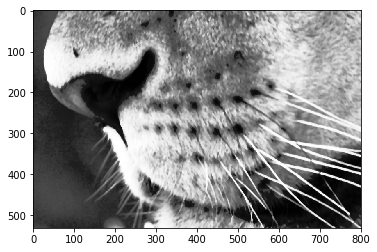

In [3]:
img = cv2.imread(test_image)
median = cv2.medianBlur(img,5)
gray = cv2.cvtColor(median, cv2.COLOR_BGR2GRAY)
norm = cv2.equalizeHist(gray)
plt.imshow(norm, cmap='gray')
plt.show()

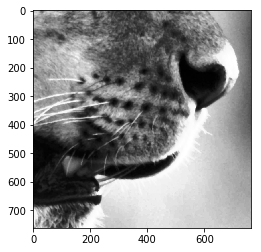

In [13]:
img2 = cv2.imread(test_image2)
median = cv2.medianBlur(img2,5)
gray2 = cv2.cvtColor(median, cv2.COLOR_BGR2GRAY)
norm2 = cv2.equalizeHist(gray2)
plt.imshow(norm2, cmap='gray')
plt.show()

## Threshold whisker region

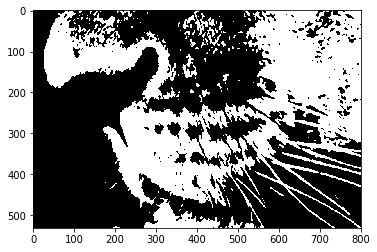

In [4]:
# threshold image
ret,thresh1 = cv2.threshold(norm,150,255,cv2.THRESH_BINARY)
plt.imshow(thresh1, cmap='gray')
plt.show()

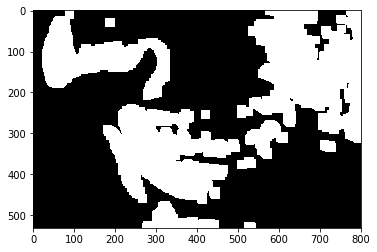

In [5]:
# clean up elements
kernel = np.ones((3,3),np.uint8)
erosion = cv2.erode(thresh1,kernel,iterations=6)
dilation = cv2.dilate(erosion,kernel,iterations = 10)
plt.imshow(dilation, cmap='gray')
plt.show()

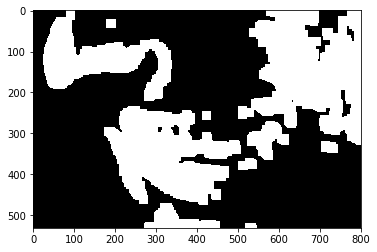

In [6]:
kernel = np.ones((2,2),np.uint8)
closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel, iterations=3)
plt.imshow(closing, cmap='gray')
plt.show()

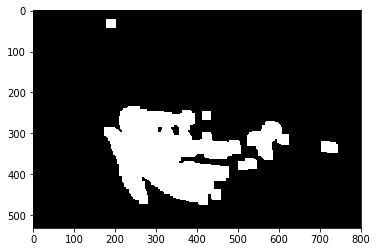

In [7]:
# remove artifacts connected to image border
cleared = clear_border(closing)
plt.imshow(cleared, cmap='gray')
plt.show()

## Binary mask to bounding boxes

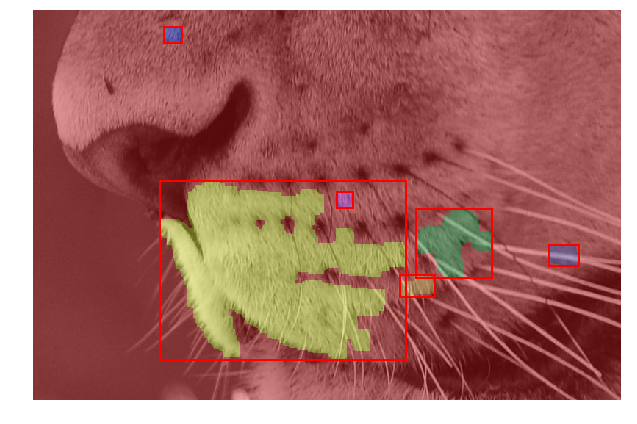

In [9]:
import matplotlib.patches as mpatches

# label image regions
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=img)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

bboxes = []

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        bboxes.append(region.bbox)
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

## Descriptors

### FAST detector

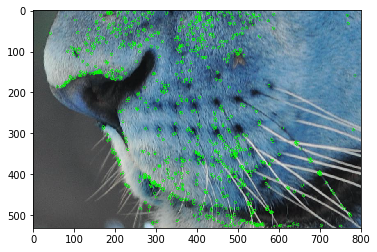

In [25]:
# Initiate FAST object with default values
# TODO: reduce number of keypoints
fast = cv2.FastFeatureDetector_create(30)

# find and draw the keypoints
kp = fast.detect(img,None)
fast_img = img.copy() 
cv2.drawKeypoints(img, kp, fast_img, color=(0,255,0))

plt.imshow(fast_img, cmap='gray')
plt.show()

### ORB descriptor

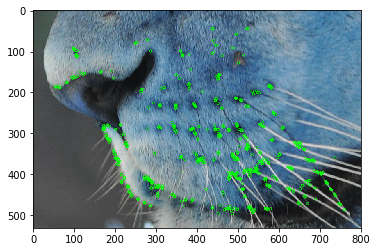

In [11]:
orb = cv2.ORB_create(nfeatures=1000,scoreType=cv2.ORB_FAST_SCORE)
kp = orb.detect(gray,None)
orb_img = cv2.drawKeypoints(img, kp, None, color=(0,255,0))

plt.imshow(orb_img, cmap='gray')
plt.show()

## Descriptor matching

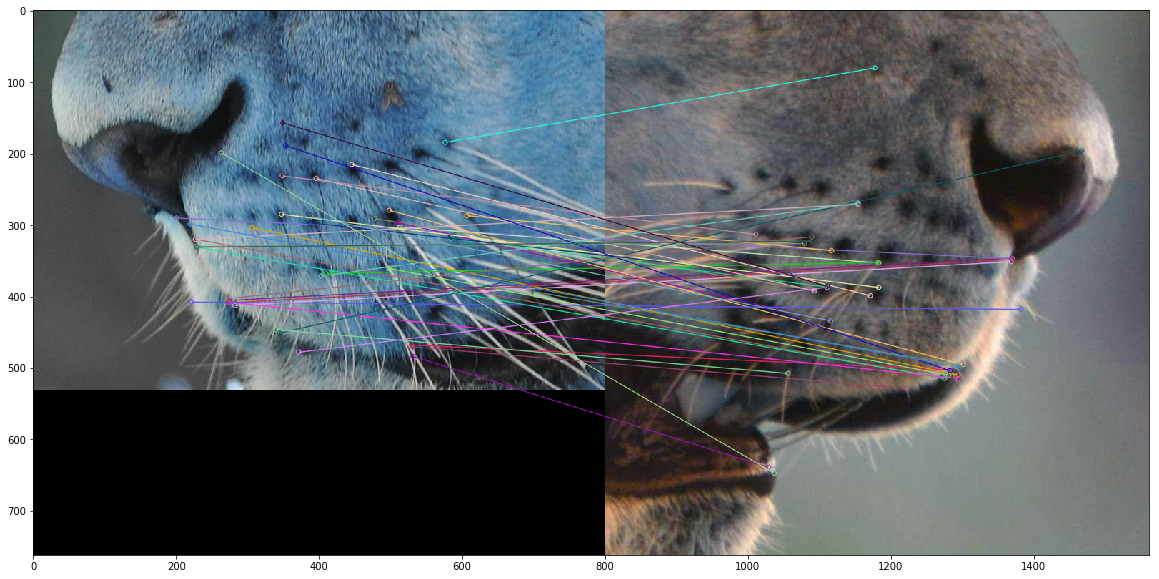

In [14]:
MIN_MATCH_COUNT = 10

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img,kp1,img2,kp2,matches[:40], None, flags=2)

plt.figure(figsize = (20,200))
plt.imshow(img3)
plt.show()

## Cascade feature detection

In [15]:
def detect_mouth(img):
    thresh = 120
    ## TODO: train haar cascade classifier for lion features
    cascPath = 'models/haarcascade_mcs_mouth.xml'
    noseCascade = cv2.CascadeClassifier(cascPath)
    nose_detection = img.copy()
    nose = noseCascade.detectMultiScale(img)
    for (ex,ey,ew,eh) in nose:
        dist = np.linalg.norm(np.asarray((ex,ey))-np.asarray((ex+ew,ey+eh)))
        if dist < thresh:
            continue
        cv2.rectangle(nose_detection,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

    return nose_detection

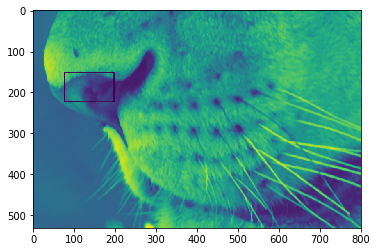

In [16]:
nose_detection = detect_mouth(gray)
plt.imshow(nose_detection)
plt.show()

In [ ]:
f